# Variant effect prediction

In [1]:
from datasets import load_dataset
from functools import reduce
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [103]:
def get_odds_ratio(df, threshold_ns):
    rows = []
    negative_set = df.filter(~pl.col("label")).sort("score")
    for n in threshold_ns:
        threshold = negative_set[n]["score"]
        group_counts = (
            df.group_by(["label", pl.col("score") <= threshold]).len()
            .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
        )
        odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
        rows.append([n, odds_ratio, p_value])
    return pl.DataFrame(rows, schema=["n", "odds_ratio", "p_value"])

def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

def plot_curve(V, results, curve, title, pos_label="Pathogenic", pos_prop=None, save_path=None):
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3,3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model==m].iloc[0][metric]
        plot_f.from_predictions(V.label==pos_label, -V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        

color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    
    "Common": color_neg,
    "Rare": color_pos,
}

def barplot(df, metric, title, pos_prop=None, save_path=None, figsize=(3,3)):
    plt.figure(figsize=figsize)
    g = sns.barplot(
        data=df.sort_values(metric, ascending=False),
        y="Model",
        x=metric,
        palette=palette,
    )
    sns.despine();
    plt.title(title, fontsize=11);
    baseline = 0.5 if metric == "AUROC" else pos_prop
    g.set(xlim=baseline)
    plt.ylabel("");

    for bar in g.patches:
        g.text(
            bar.get_width(),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

def histplot_label(V, save_path=None, **kwargs):
    V["Label"] = V.source + "/\n" + V.label
    plt.figure(figsize=(3,3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="Label",
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        
        
def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3,3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [3]:
plot_dir = "../../results/plots/"

In [4]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100-vertebrates": "C2",
    "phyloP-241-mammals": "C7",
    "phastCons-100-vertebrates": "C8",
    
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C7",
    r"Enformer ($L^2$)": "C6",
    r"Enformer ($L^\infty$)": "C8",
    
    "GPN-MSA + Enformer": "black",
    "GPN-MSA (Emb + LLR)": "black",
    
    "PrimateAI-3D": "black",
}

In [108]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    #"CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
]

nt_model = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
hyenadna_model = 'LongSafari/hyenadna-large-1m-seqlen-hf'

ablation_models = pd.read_csv("../../models.txt", header=None).values.ravel().tolist()[1:]
#ablation_models = ["msa_multiz100way/89"]
ablation_models = []

model_renaming = { 
    # GPN-MSA
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",

    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    
    # HyenaDNA models
    'LongSafari/hyenadna-large-1m-seqlen-hf': "HyenaDNA",
    
    # Other models
    "CADD.RawScore": "CADD",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)

dataset_models = {
    "ClinVar": core_models + ["ESM-1b"] + ablation_models, # + hyenadna_models #+ ["PrimateAI-3D"],

    "COSMIC": core_models + ["ESM-1b"] + ablation_models, #+ nt_models[-1:] #+ ["PrimateAI-3D"],

    "OMIM": {
        "all": core_models + ablation_models,
        "Promoter": core_models,
        "Enhancer": core_models,
        "5' UTR": core_models,
        "3' UTR": core_models,
        "ncRNA": core_models,
    },
    
    "gnomAD": {
        "all": core_models + ablation_models,
        
        "missense": core_models + ["ESM-1b"] + ablation_models, # + nt_models[-1:], # + ["PrimateAI-3D"],
        
        "synonymous": core_models + ablation_models, # + nt_models[-1:],
        "5_prime_UTR": core_models + ablation_models, # + nt_models[-1:],
        "3_prime_UTR": core_models + ablation_models, # + nt_models[-1:],
        "upstream_gene": core_models + ablation_models,
        "downstream_gene": core_models + ablation_models,
        
        "intron": core_models,  #+ ["SpliceAI"] + ablation_models,
        
        "intergenic": core_models + ablation_models,
        "non_coding_transcript_exon": core_models + ablation_models,
    },
    
    "gnomAD_Enformer": core_models, #+ ["Enformer_l1", "Enformer_l2", "Enformer_linf"],
}
models = gather_unique_values(dataset_models)

In [49]:
# leave this for later
#x = V_gnomad.filter(~pl.col("label"))["consequence"].value_counts()
#x

consequence,count
str,u32
"""synonymous""",18974
"""3_prime_UTR""",68375
"""splice_region""",4274
"""splice_accepto…",349
"""5_prime_UTR""",14897
"""downstream_gen…",64772
"""incomplete_ter…",1
"""stop_retained""",34
"""missense""",18726


In [6]:
dataset_path = "results/clinvar/merged"
V_clinvar = load_dataset("../../" + dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(dataset_models["ClinVar"]):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_clinvar[model_name] = pd.read_parquet(model_path)["score"].values
V_clinvar

100%|██████████| 52/52 [00:00<00:00, 106.15it/s]


,chrom,pos,ref,alt,label,id,review_status,consequence,AC,AN,...,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.64,msa_multiz100way/89
0,1,69511,A,G,Common,None,None,missense,70482.0,83312.0,...,1.840820,1.884766,1.591797,1.572266,1.790039,1.369141,1.740234,1.625000,1.621094,1.704748
1,1,953279,T,C,Common,None,None,missense,142160.0,152178.0,...,2.888672,2.722656,2.101562,2.796875,2.914062,2.312500,2.558594,2.660156,2.328125,1.183770
2,1,973858,G,C,Common,None,None,missense,101892.0,151984.0,...,1.843750,2.332031,1.894531,1.685547,1.728516,1.602539,1.534180,1.601562,1.527344,1.945910
3,1,973929,T,C,Common,None,None,missense,32685.0,151974.0,...,-0.966797,-1.223633,-1.472656,-0.955078,-1.650391,-1.668945,-1.439453,-1.763672,-1.775391,-0.367725
4,1,976215,A,G,Pathogenic,1320032,no_assertion_criteria_provided,missense_variant,NaN,NaN,...,-3.765625,-3.832031,-3.410156,-3.359375,-3.300781,-2.941406,-3.253906,-3.220703,-2.966797,-1.118030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40975,Y,2787426,C,G,Pathogenic,9739,"criteria_provided,_single_submitter",missense_variant,NaN,NaN,...,-7.183594,-7.046875,-6.898438,-6.773438,-6.261719,-6.101562,-6.398438,-5.570312,-6.238281,-3.806662
40976,Y,2787515,C,A,Pathogenic,492908,no_assertion_criteria_provided,missense_variant,NaN,NaN,...,-3.962891,-3.265625,-3.601562,-3.027344,-2.386719,-3.023438,-1.205078,-1.367188,-1.514648,-1.098612
40977,Y,2787551,C,T,Pathogenic,9754,no_assertion_criteria_provided,missense_variant,NaN,NaN,...,-1.624023,-1.676758,-1.402344,-1.254883,-0.917969,-0.396484,-0.640625,-0.664062,0.082031,1.252763
40978,Y,7063898,A,T,Pathogenic,625467,no_assertion_criteria_provided,missense_variant,NaN,NaN,...,-6.335938,-6.343750,-6.371094,-8.367188,-7.609375,-7.925781,-7.128906,-6.738281,-7.421875,-3.526361


In [7]:
dataset_path = "results/cosmic/merged"
V_cosmic = load_dataset("../../" + dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(dataset_models["COSMIC"]):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_cosmic[model_name] = pd.read_parquet(model_path)["score"].values
V_cosmic

100%|██████████| 52/52 [00:00<00:00, 187.21it/s]


,chrom,pos,ref,alt,GENOMIC_MUTATION_ID,consequence,n_samples,total_samples,freq,label,...,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.16,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.32,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/43/30000/True/True/True.64,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/44/30000/True/True/True.64,msa_multiz100way/89
0,1,69511,A,G,None,missense,NaN,NaN,NaN,Common,...,1.840820,1.884766,1.591797,1.572266,1.790039,1.369141,1.740234,1.625000,1.621094,1.704748
1,1,953279,T,C,None,missense,NaN,NaN,NaN,Common,...,2.888672,2.722656,2.101562,2.796875,2.914062,2.312500,2.558594,2.660156,2.328125,1.183770
2,1,973858,G,C,None,missense,NaN,NaN,NaN,Common,...,1.843750,2.332031,1.894531,1.685547,1.728516,1.602539,1.534180,1.601562,1.527344,1.945910
3,1,973929,T,C,None,missense,NaN,NaN,NaN,Common,...,-0.966797,-1.223633,-1.472656,-0.955078,-1.650391,-1.668945,-1.439453,-1.763672,-1.775391,-0.367725
4,1,976215,A,G,None,missense,NaN,NaN,NaN,Common,...,-3.765625,-3.832031,-3.410156,-3.359375,-3.300781,-2.941406,-3.253906,-3.220703,-2.966797,-1.118030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18910,X,156022062,G,A,None,missense,NaN,NaN,NaN,Common,...,-7.355469,-7.367188,-6.726562,-6.546875,-6.902344,-6.261719,-6.773438,-7.218750,-6.582031,-3.806662
18911,X,156022092,C,T,None,missense,NaN,NaN,NaN,Common,...,-5.894531,-5.632812,-5.343750,-5.214844,-5.476562,-5.082031,-5.421875,-5.769531,-5.265625,-3.044522
18912,X,156023118,G,T,None,missense,NaN,NaN,NaN,Common,...,-6.355469,-7.179688,-6.910156,-5.496094,-6.035156,-5.574219,-5.835938,-5.312500,-5.515625,-3.044522
18913,X,156024251,A,C,None,missense,NaN,NaN,NaN,Common,...,-5.199219,-5.339844,-6.019531,-4.488281,-5.722656,-5.699219,-3.726562,-4.382812,-4.433594,-3.806662


In [74]:
dataset_path = "results/omim/merged"
V_omim = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet")
    .with_columns(pl.col("label") == "Pathogenic")
)
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(gather_unique_values(dataset_models["OMIM"])):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_omim = V_omim.with_columns(pl.read_parquet(model_path)["score"].alias(model_name))
V_omim

100%|██████████| 4/4 [00:00<00:00, 23.04it/s]


chrom,pos,ref,alt,label,consequence,OMIM,Gene,PMID,AC,AN,AF,MAF,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,phyloP-100-vertebrates,phyloP-241-mammals,phastCons-100-vertebrates
str,i64,str,str,bool,str,str,str,f64,f64,f64,f64,f64,f32,f64,f64,f64
"""1""",13273,"""G""","""C""",false,"""ncRNA""",null,null,null,18928.0,120690.0,0.156832,0.156832,-4.074219,-1.091,-0.864,-1.0
"""1""",14464,"""A""","""T""",false,"""ncRNA""",null,null,null,26287.0,133502.0,0.196903,0.196903,0.89502,1.705,-0.992,-0.0
"""1""",16688,"""G""","""A""",false,"""ncRNA""",null,null,null,6711.0,98230.0,0.068319,0.068319,-4.027344,-3.121,-1.305,-0.996
"""1""",17697,"""G""","""C""",false,"""ncRNA""",null,null,null,17539.0,116050.0,0.151133,0.151133,-4.734375,-2.491,-8.751,-1.0
"""1""",49554,"""A""","""G""",false,"""Enhancer""",null,null,null,5775.0,95616.0,0.060398,0.060398,-1.988281,-0.024,0.078,-0.003
"""1""",51479,"""T""","""A""",false,"""Promoter""",null,null,null,28476.0,111172.0,0.256144,0.256144,-1.28125,0.212,-0.604,-0.001
"""1""",51803,"""T""","""C""",false,"""Promoter""",null,null,null,42169.0,110124.0,0.382923,0.382923,-1.322266,-0.393,-0.107,-0.091
"""1""",51928,"""G""","""A""",false,"""Promoter""",null,null,null,17118.0,81676.0,0.209584,0.209584,1.206055,-0.176,0.06,-0.001
"""1""",52058,"""G""","""C""",false,"""Promoter""",null,null,null,19797.0,82322.0,0.240482,0.240482,-1.276367,0.238,-0.137,-0.0


In [51]:
dataset_path = "results/gnomad/merged/filt"
V_gnomad = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet")
    .with_columns(
        pl.col("label") == "Rare",
        pl.col("consequence").str.replace("_variant", ""),
    )
)

d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(gather_unique_values(dataset_models["gnomAD"])):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_gnomad = V_gnomad.with_columns(
        pl.read_parquet(model_path)["score"].alias(model_name)
    )
V_gnomad

100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


chrom,pos,ref,alt,AC,AN,AF,consequence,MAF,label,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,ESM-1b
str,i64,str,str,i64,i64,f64,str,f64,bool,f32,f64,f64,f64,f64
"""1""",10111,"""C""","""A""",1,44330,0.000023,"""intergenic""",0.000023,true,-0.017578,null,-0.0,null,null
"""1""",10131,"""C""","""A""",1,105956,0.000009,"""intergenic""",0.000009,true,-0.347656,null,-0.0,null,null
"""1""",10139,"""A""","""T""",1,58738,0.000017,"""intergenic""",0.000017,true,-0.432617,null,-0.0,null,null
"""1""",10141,"""C""","""G""",1,50842,0.00002,"""intergenic""",0.00002,true,-0.496094,null,-0.0,null,null
"""1""",10154,"""C""","""A""",1,27646,0.000036,"""intergenic""",0.000036,true,-0.009766,null,-0.0,null,null
"""1""",10172,"""C""","""G""",1,37600,0.000027,"""intergenic""",0.000027,true,-0.439453,null,-0.0,null,null
"""1""",10193,"""A""","""T""",1,25386,0.000039,"""intergenic""",0.000039,true,-0.429688,null,-0.0,null,null
"""1""",10202,"""C""","""G""",1,71460,0.000014,"""intergenic""",0.000014,true,-2.82666,null,-0.0,null,null
"""1""",10210,"""T""","""G""",1,34822,0.000029,"""intergenic""",0.000029,true,-1.92981,null,-0.0,null,null


In [110]:
dataset_path = "results/variants_enformer/"
V_enformer = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet")
    .with_columns(pl.col("label") == "Low-frequency")
)
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(dataset_models["gnomAD_Enformer"]):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_enformer = V_enformer.with_columns(pl.read_parquet(model_path)["score"].alias(model_name))
V_enformer

100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


chrom,pos,ref,alt,AC,AN,AF,consequence,label,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,phyloP-100-vertebrates,phyloP-241-mammals,phastCons-100-vertebrates
str,i64,str,str,i64,i64,f64,str,bool,f32,f64,f64,f64
"""1""",14933,"""G""","""A""",1203,111878,0.010753,"""intron""",true,-1.240234,0.508,0.214,-0.0
"""1""",15211,"""T""","""G""",8427,71424,0.117986,"""intron""",false,-0.74707,0.944,-0.255,-0.0
"""1""",49298,"""T""","""C""",52067,87250,0.596756,"""intergenic""",false,-0.716797,-0.507,-0.306,-0.004
"""1""",49343,"""T""","""C""",1832,96808,0.018924,"""intergenic""",true,-0.386963,0.534,-0.265,-0.008
"""1""",49554,"""A""","""G""",5775,95616,0.060398,"""intergenic""",false,-1.988281,-0.024,0.078,-0.003
"""1""",51479,"""T""","""A""",28476,111172,0.256144,"""upstream_gene""",false,-1.28125,0.212,-0.604,-0.001
"""1""",52238,"""T""","""G""",100964,111364,0.906613,"""upstream_gene""",false,1.34375,1.025,-0.078,-0.0
"""1""",52253,"""C""","""G""",993,110668,0.008973,"""upstream_gene""",true,-1.455078,1.292,0.236,-0.0
"""1""",54353,"""C""","""A""",1400,117446,0.01192,"""intergenic""",true,-2.066406,1.081,0.01,-0.001


In [111]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [14]:
V_clinvar.dropna(subset=dataset_models["ClinVar"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        15404
Name: count, dtype: int64

In [15]:
rows = []
for m in tqdm(dataset_models["ClinVar"]):
    y_true = V_clinvar.label=="Pathogenic"
    y_score = -V_clinvar[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUROC", ascending=False)
results_clinvar

100%|██████████| 52/52 [00:01<00:00, 44.23it/s]


,Model,AUROC,AUPRC
24,multiz100way/89/256/128/True/defined.phastCons...,0.969021,0.976350
8,multiz100way/89/128/64/True/defined.phastCons....,0.968808,0.976230
25,multiz100way/89/256/128/True/defined.phastCons...,0.968684,0.976142
26,multiz100way/89/256/128/True/defined.phastCons...,0.968618,0.976027
0,multiz100way/89/128/64/True/defined.phastCons....,0.968483,0.975968
7,multiz100way/89/128/64/True/defined.phastCons....,0.968325,0.975908
50,multiz100way/89/128/64/True/defined.phastCons....,0.967901,0.975432
49,multiz100way/89/128/64/True/defined.phastCons....,0.967692,0.975240
48,multiz100way/89/128/64/True/defined.phastCons....,0.967619,0.975150
32,multiz100way/89/128/64/True/defined.phastCons....,0.967390,0.974818


In [16]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
clinvar_title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
clinvar_title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 15404'

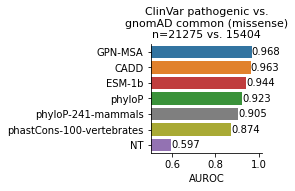

In [17]:
barplot(
    results_clinvar[~results_clinvar.Model.isin(ablation_models)].replace(models[0], "GPN-MSA"),
    "AUROC",
    clinvar_title,
    figsize=(2,2),
    #save_path="clinvar_auroc.svg",
)

In [34]:
histplot_label(
    V_clinvar,
    hue_order=["ClinVar/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_clinvar.svg",
)

AttributeError: 'DataFrame' object has no attribute 'source'

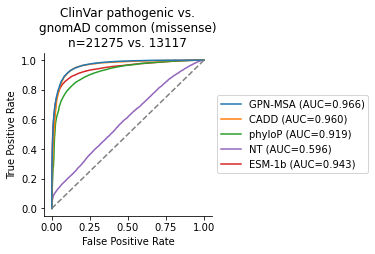

In [19]:
plot_curve(
    V_clinvar,
    results_clinvar[results_clinvar.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
    ])],
    "ROC",
    title,
    #save_path="clinvar_roc.svg",
)

### Stratifying by conservation

In [37]:
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar["conservation"] = "neutral"
V_clinvar.loc[V_clinvar.phyloP < -log_pval_thresh, "conservation"] = "conserved"
V_clinvar.loc[V_clinvar.phyloP > log_pval_thresh, "conservation"] = "accelerated"
V_clinvar.conservation.value_counts()

conservation
conserved      24890
neutral         9974
accelerated     1815
Name: count, dtype: int64

In [38]:
rows = []
for c in V_clinvar.conservation.unique():
    V_c = V_clinvar[V_clinvar.conservation==c]
    for m in dataset_models["ClinVar"]:
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([c, m, AUROC, AUPRC])
results_clinvar_strat = pd.DataFrame(rows, columns=["Conservation", "Model", "AUROC", "AUPRC"])
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC
0,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.918516,0.760613
1,neutral,CADD,0.897630,0.693334
2,neutral,phyloP,0.667646,0.227345
3,neutral,phyloP-241-mammals,0.644568,0.279631
4,neutral,phastCons-100-vertebrates,0.773005,0.363481
5,neutral,ESM-1b,0.881874,0.738660
6,neutral,NT,0.572195,0.172020
7,conserved,multiz100way/89/128/64/True/defined.phastCons....,0.939847,0.982385
8,conserved,CADD,0.931172,0.976797
9,conserved,phyloP,0.865205,0.957730


In [39]:
def get_subtitle(c):
    n_pos, n_neg = V_clinvar[V_clinvar.conservation==c].label.value_counts()[["Pathogenic", "Common"]].values
    return f"{c} (n={n_pos} vs. {n_neg})"

results_clinvar_strat["subtitle"] = results_clinvar_strat.Conservation.apply(get_subtitle)
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC,subtitle
0,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.918516,0.760613,neutral (n=1371 vs. 8603)
1,neutral,CADD,0.897630,0.693334,neutral (n=1371 vs. 8603)
2,neutral,phyloP,0.667646,0.227345,neutral (n=1371 vs. 8603)
3,neutral,phyloP-241-mammals,0.644568,0.279631,neutral (n=1371 vs. 8603)
4,neutral,phastCons-100-vertebrates,0.773005,0.363481,neutral (n=1371 vs. 8603)
5,neutral,ESM-1b,0.881874,0.738660,neutral (n=1371 vs. 8603)
6,neutral,NT,0.572195,0.172020,neutral (n=1371 vs. 8603)
7,conserved,multiz100way/89/128/64/True/defined.phastCons....,0.939847,0.982385,conserved (n=19846 vs. 5044)
8,conserved,CADD,0.931172,0.976797,conserved (n=19846 vs. 5044)
9,conserved,phyloP,0.865205,0.957730,conserved (n=19846 vs. 5044)


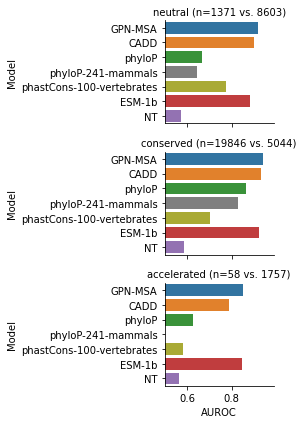

In [54]:
g = sns.catplot(
    data=results_clinvar_strat.replace(models[0], "GPN-MSA"),
    x="AUROC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);

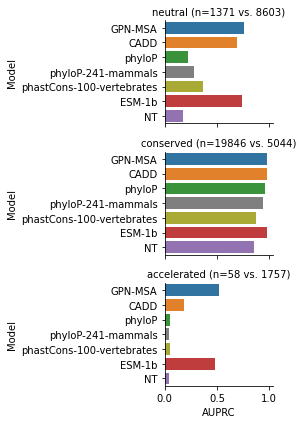

In [55]:
g = sns.catplot(
    data=results_clinvar_strat.replace(models[0], "GPN-MSA"),
    x="AUPRC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}");
#g.set(xlim=0.5);

## COSMIC frequent vs. gnomAD common (missense)

In [18]:
V_cosmic.dropna(subset=dataset_models["COSMIC"], inplace=True)
V_cosmic.label.value_counts()

label
Common      15404
Frequent      189
Name: count, dtype: int64

In [19]:
rows = []
for m in tqdm(dataset_models["COSMIC"]):
    y_true = V_cosmic.label=="Frequent"
    y_score = -V_cosmic[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_cosmic = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUPRC", ascending=False)
results_cosmic

100%|██████████| 52/52 [00:00<00:00, 83.05it/s]


,Model,AUROC,AUPRC
26,multiz100way/89/256/128/True/defined.phastCons...,0.764326,0.364738
24,multiz100way/89/256/128/True/defined.phastCons...,0.764359,0.353036
25,multiz100way/89/256/128/True/defined.phastCons...,0.763971,0.347636
0,multiz100way/89/128/64/True/defined.phastCons....,0.765721,0.344098
7,multiz100way/89/128/64/True/defined.phastCons....,0.765610,0.339058
48,multiz100way/89/128/64/True/defined.phastCons....,0.766717,0.338136
21,multiz100way_vertebrates/51/128/64/True/define...,0.765813,0.337012
23,multiz100way_vertebrates/51/128/64/True/define...,0.764512,0.331979
8,multiz100way/89/128/64/True/defined.phastCons....,0.766051,0.331123
49,multiz100way/89/128/64/True/defined.phastCons....,0.766866,0.330556


In [20]:
n_pos, n_neg = (V_cosmic.label=="Frequent").sum(), (V_cosmic.label=="Common").sum()
cosmic_title = f"COSMIC frequent vs. \ngnomAD common (missense) \n n = {n_pos} vs. {n_neg}"
cosmic_pos_prop = n_pos/(n_pos+n_neg)
cosmic_title

'COSMIC frequent vs. \ngnomAD common (missense) \n n = 189 vs. 15404'

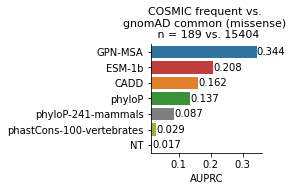

In [21]:
barplot(
    results_cosmic[~results_cosmic.Model.isin(ablation_models)].replace(models[0], "GPN-MSA"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2),
    #save_path="cosmic_auprc.svg",
)

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

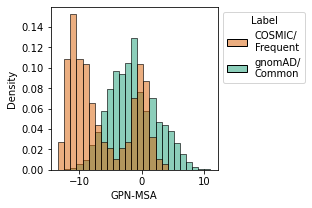

In [19]:
histplot_label(
    V_cosmic,
    hue_order=["COSMIC/\nFrequent", "gnomAD/\nCommon"],
    #save_path="hist_cosmic.svg",
)

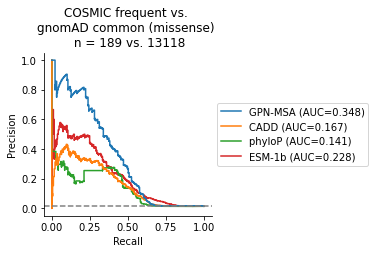

In [28]:
plot_curve(
    V_cosmic,
    results_cosmic[results_cosmic.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b",
    ])],
    "PR",
    title,
    pos_label="Frequent",
    pos_prop=pos_prop,
    save_path="cosmic_pr_curve.svg",
)

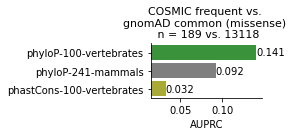

In [32]:
barplot(
    results_cosmic[results_cosmic.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2*1/2),
    #save_path="cosmic_auprc_conservation.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [77]:
consequence_models = dataset_models["OMIM"]
rows = []
for c in tqdm(consequence_models):
    V_c = V_omim if c == "all" else V_omim.filter(consequence=c)
    V_c = V_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = V_c["label"].sum(), (~V_c["label"]).sum()
    y_true = V_c["label"] 
    for m in consequence_models[c]:
        y_score = -V_c[m]
        AUROC = roc_auc_score(y_true, y_score)
        AUPRC = average_precision_score(y_true, y_score)
        rows.append([c, m, AUROC, AUPRC, n_pos, n_neg])
results_omim = pd.DataFrame(rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"])
results_omim

100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,multiz100way/89/128/64/True/defined.phastCons....,0.930498,0.127152,406,2573918
1,all,phyloP-100-vertebrates,0.871816,0.037942,406,2573918
2,all,phyloP-241-mammals,0.884964,0.028139,406,2573918
3,all,phastCons-100-vertebrates,0.830174,0.005947,406,2573918
4,Promoter,multiz100way/89/128/64/True/defined.phastCons....,0.934256,0.264671,130,61955
5,Promoter,phyloP-100-vertebrates,0.884944,0.138239,130,61955
6,Promoter,phyloP-241-mammals,0.898130,0.173210,130,61955
7,Promoter,phastCons-100-vertebrates,0.859210,0.072711,130,61955
8,Enhancer,multiz100way/89/128/64/True/defined.phastCons....,0.931244,0.069904,37,2292364
9,Enhancer,phyloP-100-vertebrates,0.880674,0.038188,37,2292364


In [83]:
results_omim.Consequence = results_omim.Consequence.replace({
    "Promoter": "promoter",
    "Enhancer": "enhancer",
})
results_omim["subtitle"] = results_omim.apply(
    lambda row: f"{row['Consequence']}\nn={format_number(row['n_pos'])} vs. {format_number(row['n_neg'])}",
    axis=1
)

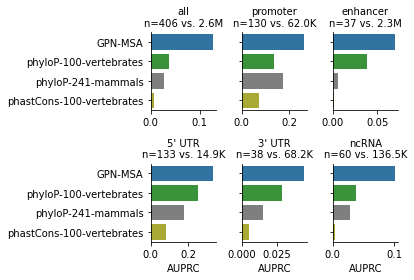

In [84]:
g = sns.catplot(
    data=results_omim[~results_omim.Model.isin(ablation_models)].replace(models[0], "GPN-MSA"),
    y="Model",
    x="AUPRC",
    col="subtitle",
    height=2,
    #aspect=1.0,
    kind="bar",
    col_wrap=3,
    sharex=False,
    #sharey=True,
    #legend=False,
    palette=palette,
)
g.set(ylabel="")
g.set_titles(col_template="{col_name}", row_template="{row_name}");
# TODO: set x_lim as pos_prop

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

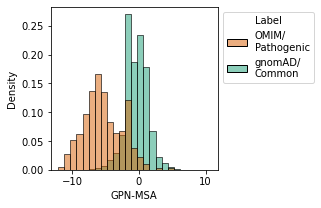

In [55]:
histplot_label(
    V_omim_all,
    hue_order=["OMIM/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_omim.svg",
)

In [18]:
replacements = {"Promoter": "promoter", "Enhancer": "enhancer"}

for key, value in replacements.items():
    results_omim['subtitle'] = results_omim['subtitle'].str.replace(key, value)

In [38]:
def omim_plot(
    df,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    g = sns.catplot(
        data=df,
        y="Model",
        x="AUPRC",
        col="subtitle",
        height=1.5,
        aspect=1.0,
        kind="bar",
        col_wrap=3,
        sharex=False,
        sharey=True,
        legend=False,
        palette=palette,
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}");
    for i, ax in enumerate(g.axes):
        ax.set_xlim(left=pos_prop[i])
        ax.set_ylabel("")
    g.fig.suptitle(title, y=y, fontsize=12, x=x)
    g.figure.subplots_adjust(wspace=1.0, hspace=1.0)

    for ax in g.axes.flat:
        for bar in ax.patches:
            ax.text(
                bar.get_width(),  # X position, here at the end of the bar
                bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
                f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
                va='center'  # Vertical alignment
            )
    
    """
    # Get current x-tick labels
    catplot = g
    current_labels = [item.get_text() for item in catplot.ax.get_xticklabels()]

    # Convert to float and format with desired number of significant figures
    n_significant_figures = 2
    formatted_labels = [f"{float(label):.{n_significant_figures}g}" if label.replace('.','',1).isdigit() else label for label in current_labels]

    # Set new labels
    catplot.set_xticklabels(formatted_labels)
    """

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

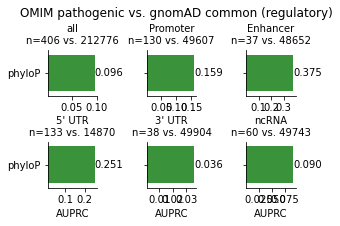

In [39]:
omim_plot(
    results_omim[results_omim.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT",
    ])],
    x=0.6,
    #save_path="omim_auprc.svg",
)

In [37]:
title = "OMIM pathogenic vs.\ngnomAD common (regulatory)" + "\n" + results_omim[results_omim.Consequence=="all"].subtitle.iloc[0]

In [38]:
def omim_curve_plot(
    subset_models,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = 'Recall'
    ylabel = 'Precision'
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))
    
    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
        pos_prop = n_pos/(n_pos+n_neg)
        subtitle = get_subtitle(c, n_pos, n_neg)

        for m in np.array(consequence_models[c])[::-1]:
            if m not in subset_models: continue
            AUC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
            plot_f.from_predictions(V_c.label==pos_label, -V_c[m], name=m, ax=ax, label=f"{m}\n(AUC={AUC:.3f})", color=palette[m])

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend();
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(handles, labels)#, loc='center left', bbox_to_anchor=(1, 0.5))    

        ax.set_title(subtitle)
        i += 1
    
    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5) 

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

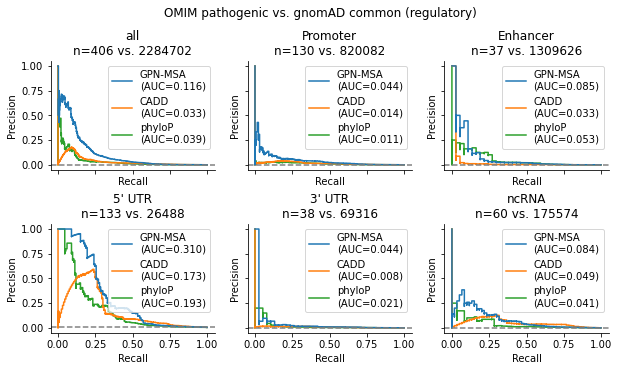

In [39]:
omim_curve_plot(
    subset_models=["GPN-MSA", "CADD", "phyloP"],
    save_path="omim_pr_curves.svg",
)

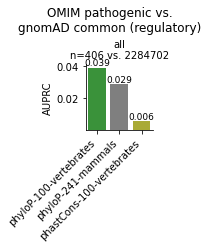

In [57]:
omim_plot(
    results_omim[(results_omim.Consequence=="all") & results_omim.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    title="OMIM pathogenic vs.\ngnomAD common (regulatory)",
    x=0.2, y=1.15,
    #save_path="omim_auprc_conservation.svg",
)

## gnomAD rare vs. common (Polars)

In [58]:
consequence_models = dataset_models["gnomAD"]
results = []
for c in tqdm(list(consequence_models.keys())):  
    df_c = V_gnomad if c == "all" else V_gnomad.filter(consequence=c)
    df_c = df_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in consequence_models[c]:
        odds_ratio = (
            get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
            .with_columns(
                Consequence=pl.lit(c), Model=pl.lit(m),
                n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
            )
        )
        results.append(odds_ratio)
results = pl.concat(results).to_pandas()
results

100%|██████████| 10/10 [03:17<00:00, 19.74s/it]


,n,odds_ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,103.725214,0.000000e+00,all,multiz100way/89/128/64/True/defined.phastCons....,252706195,5894721
1,60,76.681433,0.000000e+00,all,multiz100way/89/128/64/True/defined.phastCons....,252706195,5894721
2,90,62.576950,0.000000e+00,all,multiz100way/89/128/64/True/defined.phastCons....,252706195,5894721
3,30,35.307461,0.000000e+00,all,phyloP,252706195,5894721
4,60,27.396477,0.000000e+00,all,phyloP,252706195,5894721
...,...,...,...,...,...,...,...
118,60,2.053663,2.046544e-10,non_coding_transcript_exon,phyloP-241-mammals,5994226,136491
119,90,1.866035,2.885235e-11,non_coding_transcript_exon,phyloP-241-mammals,5994226,136491
120,30,1.234037,3.401454e-79,non_coding_transcript_exon,phastCons-100-vertebrates,5994226,136491
121,60,1.234037,3.401454e-79,non_coding_transcript_exon,phastCons-100-vertebrates,5994226,136491


In [69]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
}
results['Consequence'] = results['Consequence'].replace(replacements)
results["subtitle"] = results.apply(
    lambda row: f"{row['Consequence']}\nn={format_number(row['n_pos'])} vs. {format_number(row['n_neg'])}",
    axis=1
)

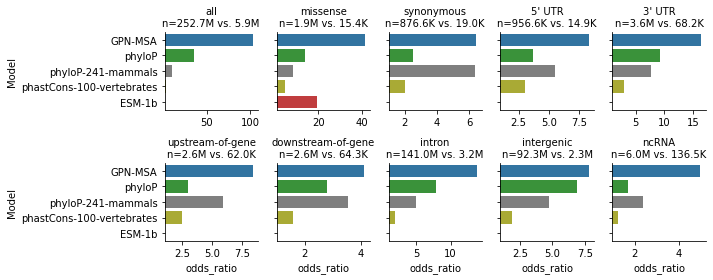

In [70]:
g = sns.catplot(
    data=results[results.n==30].replace(models[0], "GPN-MSA"),
    x="odds_ratio",
    y="Model",
    col="subtitle",
    kind="bar",
    height=2,
    col_wrap=5,
    sharex=False,
    palette=palette,
)
g.set(xlim=1)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

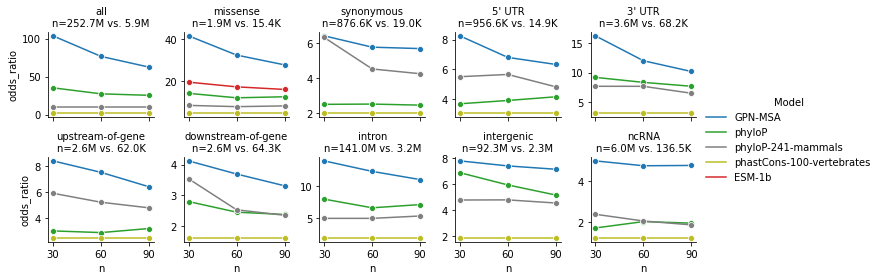

In [64]:
g = sns.relplot(
    data=results[results.p_value<=0.05].replace(models[0], "GPN-MSA"),
    x="n",
    y="odds_ratio",
    hue="Model",
    col="subtitle",
    kind="line",
    marker="o",
    height=2,
    col_wrap=5,
    facet_kws={'sharey': False, 'sharex': True},
    palette=palette,
    #markersize=5,
)
g.set(xticks=threshold_ns)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

## gnomAD rare vs. common

In [48]:
V_gnomad.label = V_gnomad.label == "Rare"

### Classification metrics

In [49]:
# TODO: implement in polars
# could do V_gnomad = pl.from_pandas(V_gnomad)

def calculate_p_at_k(df, score, label, k):
    # lower score -> higher chance of label
    return df.sort_values(score).head(k)["label"].mean()

def calculate_ap_at_k(df, score, label, k):
    # lower score -> higher chance of label
    df_sorted = df.sort_values(score).head(k).copy()
    df_sorted['p_at_k'] = df_sorted['label'].cumsum() / np.arange(1, k+1)
    
    # v1: only average at relevant items
    # there seems to be a bug anyway
    #return (df_sorted['p_at_k'] * df_sorted['label']).sum() / k 

    # v2
    return df_sorted["p_at_k"].mean()

In [63]:
consequence_models = dataset_models["gnomAD"]

rows = []
for c in tqdm(list(consequence_models.keys())):  
    if c == "all":
        df_c = V_gnomad
    else:
        df_c = V_gnomad[V_gnomad.consequence==c]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    #df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42)
    #print(c, df_c.label.value_counts())
    
    k = int((5/100) * df_c.label.sum())  # 1% of rare, or 0.1% of rare
    print(f"{c=} {k=}")

    for m in consequence_models[c]:
        #if m in ablation_models[1:]: continue
        #auroc = roc_auc_score(df_c.label, -df_c[m])
        #p_at_k = calculate_p_at_k(df_c[[m, "label"]], m, "label", k)
        ap_at_k = calculate_ap_at_k(df_c[[m, "label"]], m, "label", k)
        rows.append([m, c, ap_at_k])
results_gnomad2 = pd.DataFrame(rows, columns=["Model", "Consequence", "AP@K"])
results_gnomad2

  0%|          | 0/10 [00:00<?, ?it/s]

c='all' k=223607


 20%|██        | 2/10 [00:04<00:15,  1.88s/it]

c='missense' k=24979


 30%|███       | 3/10 [00:04<00:09,  1.33s/it]

c='synonymous' k=24981


 40%|████      | 4/10 [00:05<00:06,  1.06s/it]

c='5_prime_UTR' k=24968
c='3_prime_UTR' k=24968


 60%|██████    | 6/10 [00:06<00:03,  1.19it/s]

c='upstream_gene' k=24855
c='downstream_gene' k=24863


 70%|███████   | 7/10 [00:07<00:02,  1.27it/s]

c='intron' k=24814


 80%|████████  | 8/10 [00:08<00:01,  1.19it/s]

c='intergenic' k=24283


 90%|█████████ | 9/10 [00:09<00:00,  1.16it/s]

c='non_coding_transcript_exon' k=24891


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


,Model,Consequence,AP@K
0,multiz100way/89/128/64/True/defined.phastCons....,all,0.996951
1,phyloP,all,0.989419
2,phyloP-241-mammals,all,0.987432
3,multiz100way/89/128/64/True/defined.phastCons....,missense,0.999484
4,phyloP,missense,0.997451
5,phyloP-241-mammals,missense,0.995543
6,multiz100way/89/128/64/True/defined.phastCons....,synonymous,0.993276
7,phyloP,synonymous,0.984410
8,phyloP-241-mammals,synonymous,0.990887
9,multiz100way/89/128/64/True/defined.phastCons....,5_prime_UTR,0.996343


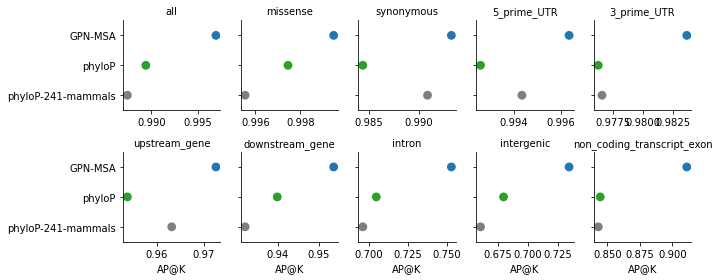

In [65]:
g = sns.catplot(
    data=results_gnomad2[~results_gnomad2.Model.isin(ablation_models)].replace(models[0], "GPN-MSA"),
    y="Model",
    x="AP@K",
    col="Consequence",
    height=2,
    #aspect=1.0,
    #kind="bar",
    kind="point",
    col_wrap=5,
    sharex=False,
    #sharey=True,
    #legend=False,
    palette=palette,
)
for ax in g.axes.flat:
    ax.set_ylabel("")
g.set_titles(col_template="{col_name}", row_template="{row_name}");
#g.set(xlim=0.5);

### Stratifying by conservation

In [26]:
df = V_gnomad.dropna(subset=dataset_models["gnomAD"]["all"])
df.shape

(699117, 18)

In [27]:
log_pval_thresh = -np.log10(0.05)  # 1.3
df["conservation"] = "neutral"
df.loc[df.phyloP < -log_pval_thresh, "conservation"] = "conserved"
df.loc[df.phyloP > log_pval_thresh, "conservation"] = "accelerated"
df.conservation.value_counts()

conservation
neutral        550276
accelerated     86804
conserved       62037
Name: count, dtype: int64

In [28]:
rows = []
for c in df.conservation.unique():
    V_c = df[df.conservation==c]
    print(c, V_c.label.value_counts())
    for m in dataset_models["gnomAD"]["all"]:
        AUROC = roc_auc_score(V_c.label, -V_c[m])
        AUPRC = average_precision_score(V_c.label, -V_c[m])
        rows.append([c, m, AUROC, AUPRC])
results_gnomad_strat = pd.DataFrame(rows, columns=["Conservation", "Model", "AUROC", "AUPRC"])
results_gnomad_strat

accelerated label
False    60999
True     25805
Name: count, dtype: int64
neutral label
True     283051
False    267225
Name: count, dtype: int64
conserved label
True     40851
False    21186
Name: count, dtype: int64


,Conservation,Model,AUROC,AUPRC
0,accelerated,multiz100way/89/128/64/True/defined.phastCons....,0.642380,0.397658
1,accelerated,CADD,0.440817,0.276910
2,accelerated,phyloP,0.554363,0.334847
3,accelerated,phyloP-241-mammals,0.577681,0.367686
4,accelerated,phastCons-100-vertebrates,0.435768,0.279541
5,accelerated,NT,0.628689,0.381148
6,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.662062,0.630377
7,neutral,CADD,0.542492,0.552984
8,neutral,phyloP,0.579666,0.572036
9,neutral,phyloP-241-mammals,0.575167,0.568120


In [29]:
def get_subtitle(c):
    labels = df[df.conservation==c].label
    n_pos, n_neg = labels.sum(), (~labels).sum()
    return f"{c} (n={n_pos} vs. {n_neg})"

results_gnomad_strat["subtitle"] = results_gnomad_strat.Conservation.apply(get_subtitle)
results_gnomad_strat

,Conservation,Model,AUROC,AUPRC,subtitle
0,accelerated,multiz100way/89/128/64/True/defined.phastCons....,0.642380,0.397658,accelerated (n=25805 vs. 60999)
1,accelerated,CADD,0.440817,0.276910,accelerated (n=25805 vs. 60999)
2,accelerated,phyloP,0.554363,0.334847,accelerated (n=25805 vs. 60999)
3,accelerated,phyloP-241-mammals,0.577681,0.367686,accelerated (n=25805 vs. 60999)
4,accelerated,phastCons-100-vertebrates,0.435768,0.279541,accelerated (n=25805 vs. 60999)
5,accelerated,NT,0.628689,0.381148,accelerated (n=25805 vs. 60999)
6,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.662062,0.630377,neutral (n=283051 vs. 267225)
7,neutral,CADD,0.542492,0.552984,neutral (n=283051 vs. 267225)
8,neutral,phyloP,0.579666,0.572036,neutral (n=283051 vs. 267225)
9,neutral,phyloP-241-mammals,0.575167,0.568120,neutral (n=283051 vs. 267225)


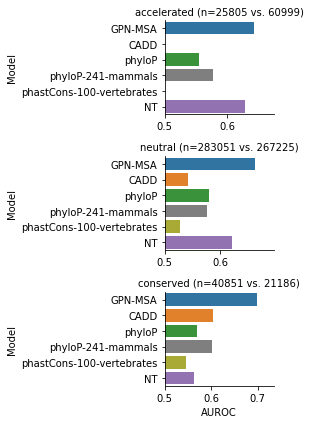

In [30]:
g = sns.catplot(
    data=results_gnomad_strat.replace(models[0], "GPN-MSA"),
    x="AUROC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
    sharex=False,
)
g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);

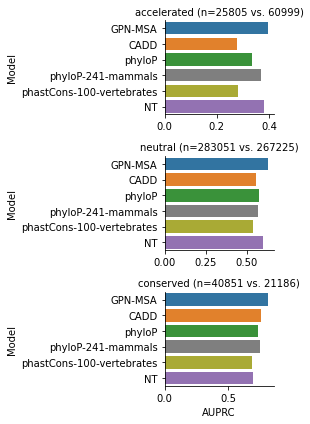

In [31]:
# TODO: set xlim to pos_prop
g = sns.catplot(
    data=results_gnomad_strat.replace(models[0], "GPN-MSA"),
    x="AUPRC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
    sharex=False,
)
g.set_titles(row_template="{row_name}");
#g.set(xlim=0.5);

In [15]:
#V_gnomad = V[V.source == "gnomAD"].copy()
#V_gnomad.label.value_counts()

In [16]:
# Drop 32 variants with MAF 1/n but AF > 0.5
# In the case of GPN-MSA and other LLR-based methods, it would be easy
# to include these variants in the analysis by "folding" (considering the major as the reference)
# (flipping the scores when AF > 0.5)
# but CADD and phyloP are only computed assuming a fixed ref
#V_gnomad = V_gnomad[V_gnomad.AC != V_gnomad.AN - 1].copy()
#V_gnomad.label.value_counts()

In [52]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    if threshold == df[model_name].max():  # happens with SpliceAI
        print("WARNING: threshold == max(score)", threshold_quantile, model_name)
        return None, None, None, None, None, None
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    odds_ratio, p_value, min_counts, ci_lower, ci_upper = _compute_odds_ratio(df)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper, threshold

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [[False, 'High'],
         [False, 'Low'],
         [True, 'High'],
         [True, 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    #if np.isinf(odds_ratio):
    #    print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [53]:
threshold_quantiles = np.logspace(-5, -1, 21)
#threshold_quantiles = np.logspace(-2, 0, 11)[:-1]

consequence_models = dataset_models["gnomAD"]

rows = []
for c in list(consequence_models.keys()):
    #if c != "all": continue  # temporary    
    print(c)
    if c == "all":
        df_c = V_gnomad
    else:
        df_c = V_gnomad[V_gnomad.consequence == c]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    
    for m in tqdm(consequence_models[c]):
        subtitle = get_subtitle(c, (df_c.label).sum(), (~df_c.label).sum())
        for tq in threshold_quantiles:
            #if tq != 1e-2: continue
            if m in ablation_models[1:]: continue
            #if m in ablation_models[1:] and tq != 1e-2: continue #1e-3: continue
            OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, threshold, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Consequence", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold", "subtitle"])
results_gnomad

all


100%|██████████| 3/3 [01:23<00:00, 27.73s/it]


missense


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


synonymous


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


5_prime_UTR


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


3_prime_UTR


100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


upstream_gene


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


downstream_gene


100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


intron


100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


intergenic


100%|██████████| 3/3 [00:11<00:00,  3.93s/it]


non_coding_transcript_exon


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


,Model,Consequence,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,all,0.000010,inf,1.502040e-07,0,NaN,inf,-13.239323,all\nn=4472152 vs. 1364521
1,multiz100way/89/128/64/True/defined.phastCons....,all,0.000016,inf,4.637768e-12,0,NaN,inf,-13.171875,all\nn=4472152 vs. 1364521
2,multiz100way/89/128/64/True/defined.phastCons....,all,0.000025,inf,4.491851e-18,0,NaN,inf,-13.085938,all\nn=4472152 vs. 1364521
3,multiz100way/89/128/64/True/defined.phastCons....,all,0.000040,inf,8.660846e-28,0,NaN,inf,-12.992188,all\nn=4472152 vs. 1364521
4,multiz100way/89/128/64/True/defined.phastCons....,all,0.000063,inf,2.279679e-45,0,NaN,inf,-12.890625,all\nn=4472152 vs. 1364521
...,...,...,...,...,...,...,...,...,...,...
625,phyloP-241-mammals,non_coding_transcript_exon,0.015849,1.541648,1.734652e-59,1526,1.457792,1.630327,-5.971000,non_coding_transcript_exon\nn=497834 vs. 136491
626,phyloP-241-mammals,non_coding_transcript_exon,0.025119,1.394930,8.249724e-58,2635,1.336098,1.456352,-4.691000,non_coding_transcript_exon\nn=497834 vs. 136491
627,phyloP-241-mammals,non_coding_transcript_exon,0.039811,1.341080,4.998152e-71,4326,1.296281,1.387428,-3.329000,non_coding_transcript_exon\nn=497834 vs. 136491
628,phyloP-241-mammals,non_coding_transcript_exon,0.063096,1.359107,1.311198e-118,6820,1.322479,1.396751,-2.191000,non_coding_transcript_exon\nn=497834 vs. 136491


/tmp/ipykernel_2801289/2596275445.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["Label"] = V.source + "/\n" + V.label
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaf

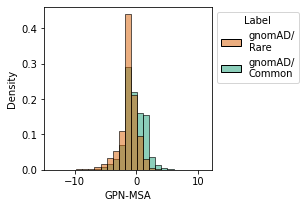

In [ ]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
    #save_path="hist_gnomad.svg",
)

(0.0, 0.007)

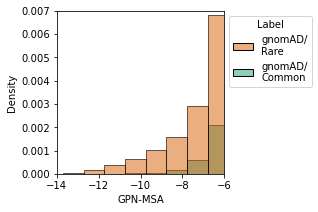

In [116]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
#plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

In [54]:
print("Careful if inf, should handle separately: ", results_gnomad["Odds ratio"].max())

Careful if inf, should handle separately:  inf


In [55]:
limit_per_consequence = results_gnomad.query("min_counts < 10").groupby("Consequence")["Quantile threshold"].max()
limit_per_consequence

Consequence
3_prime_UTR                   0.002512
5_prime_UTR                   0.010000
all                           0.002512
downstream_gene               0.000631
intergenic                    0.000100
intron                        0.000100
missense                      0.025119
non_coding_transcript_exon    0.000251
synonymous                    0.002512
upstream_gene                 0.001585
Name: Quantile threshold, dtype: float64

In [56]:
def above_limit(r):
    try:
         l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Quantile threshold"] > l

results_gnomad["above_limit"] = results_gnomad.apply(above_limit, axis=1)

In [57]:
results_gnomad[results_gnomad.above_limit].min_counts.min()

10

In [58]:
results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min()

0.00015848931924611142

In [58]:
"""
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
}

for key, value in replacements.items():
    results_gnomad['subtitle'] = results_gnomad['subtitle'].str.replace(key, value)
    results_gnomad['Consequence'] = results_gnomad['Consequence'].str.replace(key, value)
""";

In [59]:
"""
x = results_gnomad.subtitle.drop_duplicates()
x = "``" + results_gnomad.Consequence.drop_duplicates() + "'': " + x.str.split('\n').str[-1].str.replace("n=", "$n=$ ")
x = ", ".join(x.values)
x
""";

In [59]:
def gnomad_plot(df, save_path=None, y=1.15, height=2.1):
    g = sns.relplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        col="subtitle",
        #col="Consequence",
        height=height,
        kind="line",
        marker="o",
        col_wrap=min(5, len(df.subtitle.unique())),
        facet_kws={'sharey': False, 'sharex': False},
        palette=palette,
        markersize=5,
    )

    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=1.0)
    g.fig.subplots_adjust(
        hspace=1.2,
        #wspace=0.5,
    ) # 1.0 # modification
    plt.suptitle("gnomAD rare vs. common", y=y);
    for ax in g.axes.flat:
        xticks = df[(df.p_value<=0.05) & (df.above_limit)]["Quantile threshold"].drop_duplicates().values
        xticks = xticks[::2]
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{x:.2e}" for x in xticks])

    #    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
        ax.tick_params(axis='x', rotation=45)

    """
    for ax, subtitle in zip(g.axes.flat, g.col_names):
        ax.set_title(ax.get_title(), fontweight='bold')
        
        xticks = [1e-4, 1e-3, 1e-2, 1e-1]
        ax.set_xticks(xticks)
        left = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min() * 0.8
        right = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].max() / 0.8
        ax.set_xlim(left=left, right=right)
        ax.set_xlabel("Quantile threshold")

        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Consequence'] == subtitle) & (df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")
    """
  
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

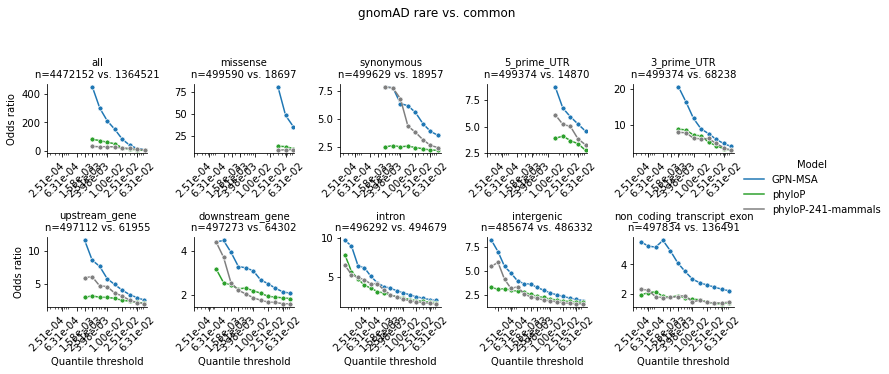

In [61]:
gnomad_plot(
    results_gnomad[results_gnomad.Model.isin([
        models[0], "CADD", "phyloP", "ESM-1b", "SpliceAI", "NT", "PrimateAI-3D", "phyloP-241-mammals",
    ])].replace(models[0], "GPN-MSA"),
    y=1.13,
    #save_path="gnomad_or.svg",
    #save_path="gnomad_or_missense.pdf",
)

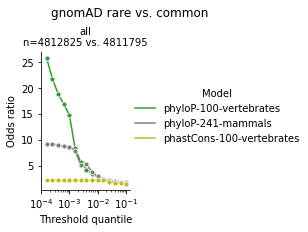

In [90]:
gnomad_plot(
    results_gnomad[(results_gnomad.Consequence=="all") & results_gnomad.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    y=1.25, height=2.5,
    #save_path="gnomad_or_conservation.svg",
)

## gnomAD Enformer set (low-frequency vs. common)

In [114]:
enformer_models = dataset_models["gnomAD_Enformer"]
results_enformer = []
df_c = V_enformer.drop_nulls(subset=enformer_models)
n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
for m in enformer_models:
    odds_ratio = (
        get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
        .with_columns(Model=pl.lit(m), n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg))
    )
    results_enformer.append(odds_ratio)
results_enformer = pl.concat(results_enformer).to_pandas()
results_enformer

,n,odds_ratio,p_value,Model,n_pos,n_neg
0,30,3.387194,1.141404e-11,multiz100way/89/128/64/True/defined.phastCons....,7627870,6208835
1,60,3.202563,3.226402e-19,multiz100way/89/128/64/True/defined.phastCons....,7627870,6208835
2,90,2.848963,6.328104e-22,multiz100way/89/128/64/True/defined.phastCons....,7627870,6208835
3,30,2.415661,5.162182e-06,phyloP-100-vertebrates,7627870,6208835
4,60,3.015741,5.370033e-17,phyloP-100-vertebrates,7627870,6208835
5,90,2.817653,3.516028e-21,phyloP-100-vertebrates,7627870,6208835
6,30,2.308760,1.161764e-15,phyloP-241-mammals,7627870,6208835
7,60,2.308760,1.161764e-15,phyloP-241-mammals,7627870,6208835
8,90,2.308760,1.161764e-15,phyloP-241-mammals,7627870,6208835
9,30,1.273218,0.000000e+00,phastCons-100-vertebrates,7627870,6208835


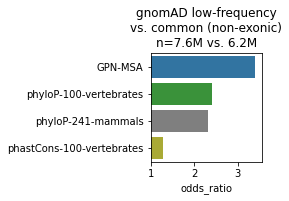

In [127]:
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=results_enformer[results_enformer.n==30].replace(models[0], "GPN-MSA"),
    x="odds_ratio",
    y="Model",
    palette=palette,
)
g.set(xlim=1, ylabel="");
plt.title(f"gnomAD low-frequency\nvs. common (non-exonic)\nn={format_number(n_pos)} vs. {format_number(n_neg)}");

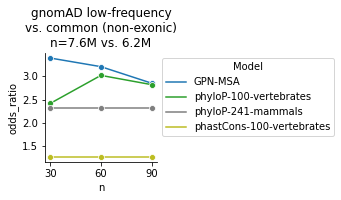

In [123]:
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=results_enformer[results_enformer.p_value<=0.05].replace(models[0], "GPN-MSA"),
    x="n",
    y="odds_ratio",
    hue="Model",
    marker="o",
    palette=palette,
)
g.set(xticks=[30, 60, 90])
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"gnomAD low-frequency\nvs. common (non-exonic)\nn={format_number(n_pos)} vs. {format_number(n_neg)}");

### Classification metrics

In [25]:
consequence_models = dataset_models["gnomAD_Enformer"]

rows = []
for c in tqdm(list(consequence_models.keys())):  
    df_c = V_enformer[V_enformer.consequence==c]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42)
    print(c, df_c.label.value_counts())
    k = int((1/100) * (1/2) * len(df_c))
    #k = int((0.1/100) * (1/2) * len(df_c))  # 1% of positive set
    print(f"{k=}")
    
    for m in consequence_models[c]:
        auroc = roc_auc_score(df_c.label, -df_c[m])
        ap_at_k = calculate_ap_at_k(df_c[[m, "label"]], m, "label", k)
        rows.append([m, c, auroc, ap_at_k])
results_enformer2 = pd.DataFrame(rows, columns=["Model", "Consequence", "AUROC", "AP@K"])
results_enformer2

  0%|          | 0/2 [00:00<?, ?it/s]

upstream_gene label
False    49649
True     49649
Name: count, dtype: int64
k=496


 50%|█████     | 1/2 [00:00<00:00,  2.09it/s]

intergenic label
False    48737
True     48737
Name: count, dtype: int64
k=487


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


,Model,Consequence,AUROC,AP@K
0,multiz100way/89/128/64/True/defined.phastCons....,upstream_gene,0.585556,0.660345
1,CADD,upstream_gene,0.490452,0.573698
2,phyloP,upstream_gene,0.564918,0.609056
3,phyloP-241-mammals,upstream_gene,0.552968,0.688263
4,phastCons-100-vertebrates,upstream_gene,0.522353,0.597472
5,NT,upstream_gene,0.560211,0.596173
6,Enformer_l1,upstream_gene,0.514043,0.556639
7,Enformer_l2,upstream_gene,0.513359,0.545726
8,Enformer_linf,upstream_gene,0.510934,0.547483
9,multiz100way/89/128/64/True/defined.phastCons....,intergenic,0.571834,0.537621


In [26]:
for n in [50, 100, 200, 500]:
    print(
        V_enformer[V_enformer.consequence=="intergenic"].sort_values(models[0]).head(n).label.sum(),
        V_enformer[V_enformer.consequence=="intergenic"].sort_values("phyloP-241-mammals").head(n).label.sum()
    )

23 31
56 55
109 112
259 276


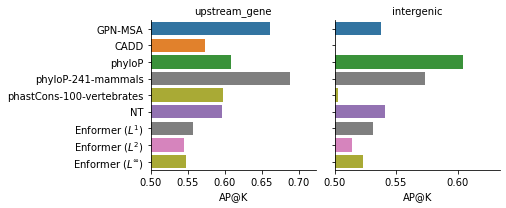

In [27]:
g = sns.catplot(
    data=results_enformer2.replace({
        models[0]: "GPN-MSA",
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    y="Model",
    x="AP@K",
    col="Consequence",
    height=3,
    #aspect=1.0,
    kind="bar",
    col_wrap=5,
    sharex=False,
    #sharey=True,
    #legend=False,
    palette=palette,
)
for ax in g.axes.flat:
    ax.set_ylabel("")
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.set(xlim=0.5);

In [33]:
threshold_quantiles = np.logspace(-5, -1, 21)

rows = []

for c in dataset_models["gnomAD_Enformer"].keys():
    df_c = V_enformer[V_enformer.consequence==c].dropna(subset=dataset_models["gnomAD_Enformer"][c])

    for m in tqdm(dataset_models["gnomAD_Enformer"][c]):
        for tq in threshold_quantiles:
            OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
            rows.append([c, m, tq, OR, p_value, min_counts, cil, ciu, threshold])
results_enformer = pd.DataFrame(rows, columns=["Consequence", "Model", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold"])
results_enformer

100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


,Consequence,Model,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold
0,upstream_gene,multiz100way/89/128/64/True/defined.phastCons....,0.000010,0.000000,1.000000,0,0.000000,NaN,-9.260063
1,upstream_gene,multiz100way/89/128/64/True/defined.phastCons....,0.000016,0.000000,1.000000,0,0.000000,NaN,-9.199514
2,upstream_gene,multiz100way/89/128/64/True/defined.phastCons....,0.000025,0.000000,1.000000,0,0.000000,NaN,-9.113741
3,upstream_gene,multiz100way/89/128/64/True/defined.phastCons....,0.000040,0.333434,0.937461,1,0.033116,3.357262,-8.921287
4,upstream_gene,multiz100way/89/128/64/True/defined.phastCons....,0.000063,1.333817,0.499813,3,0.289519,6.144900,-8.785964
...,...,...,...,...,...,...,...,...,...
373,intergenic,Enformer_linf,0.015849,1.126350,0.010792,733,1.016614,1.247932,-0.081177
374,intergenic,Enformer_linf,0.025119,1.120002,0.002976,1164,1.031976,1.215537,-0.062013
375,intergenic,Enformer_linf,0.039811,1.094586,0.003010,1870,1.025246,1.168615,-0.046997
376,intergenic,Enformer_linf,0.063096,1.047068,0.041306,3030,0.993413,1.103622,-0.034882


In [35]:
limit_per_consequence = results_enformer.query("min_counts < 10").groupby("Consequence")["Quantile threshold"].max()
limit_per_consequence

Consequence
intergenic       0.000251
upstream_gene    0.000251
Name: Quantile threshold, dtype: float64

In [36]:
def above_limit(r):
    try:
         l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Quantile threshold"] > l

results_enformer["above_limit"] = results_enformer.apply(above_limit, axis=1)

In [37]:
results_enformer[results_enformer.above_limit].min_counts.min()

13

In [43]:
def enformer_plot(df, save_path=None, y=1.15, height=2.1):
    g = sns.relplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        #col="subtitle",
        col="Consequence",
        height=height,
        kind="line",
        marker="o",
        col_wrap=2,
        facet_kws={'sharey': False, 'sharex': False},
        palette=palette,
        markersize=5,
    )

    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=1.0)
    g.fig.subplots_adjust(
        hspace=1.2,
        #wspace=0.5,
    ) # 1.0 # modification
    plt.suptitle("gnomAD rare vs. common", y=y);
    for ax in g.axes.flat:
        xticks = df[(df.p_value<=0.05) & (df.above_limit)]["Quantile threshold"].drop_duplicates().values
        xticks = xticks[::2]
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{x:.2e}" for x in xticks])

    #    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
        ax.tick_params(axis='x', rotation=45)

    """
    for ax, subtitle in zip(g.axes.flat, g.col_names):
        ax.set_title(ax.get_title(), fontweight='bold')
        
        xticks = [1e-4, 1e-3, 1e-2, 1e-1]
        ax.set_xticks(xticks)
        left = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min() * 0.8
        right = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].max() / 0.8
        ax.set_xlim(left=left, right=right)
        ax.set_xlabel("Quantile threshold")

        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Consequence'] == subtitle) & (df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")
    """
  
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

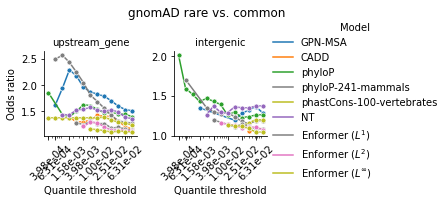

In [44]:
enformer_plot(
    results_enformer.replace({
        models[0]: "GPN-MSA",
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    y=1.13,
    #save_path="gnomad_or.svg",
    #save_path="gnomad_or_missense.pdf",
)

In [167]:
n_pos, n_neg = (df_c.label=="Rare").sum(), (df_c.label=="Common").sum()
title = f"gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)"  #\nn={n_pos} vs. {n_neg}"
title

'gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)'

In [168]:
limit = results_enformer.query("min_counts < 10")["Quantile threshold"].max()
limit

9.999999999999999e-06

In [169]:
def above_limit(r):
    return np.isnan(limit) or r["Quantile threshold"] > limit + 1e-8

results_enformer["above_limit"] = results_enformer.apply(above_limit, axis=1)

In [182]:
def enformer_plot(df, save_path=None):
    plt.figure(figsize=(2,2))
    g = sns.lineplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        marker="o",
        palette=palette,
        markersize=5,
    )
    #for ax in g.axes: ax.axhline(1, ls='--', color="grey")
    #g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=0.75)
    #plt.suptitle("gnomAD rare vs. common", y=0.9);
    sns.despine()
    #ax.set_ylim(bottom=pos_prop[i])
    plt.ylim(bottom=1)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    #g.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    ax = g     
    xticks = [1e-4, 1e-3, 1e-2, 1e-1]
    ax.set_xticks(xticks)

    if "GPN-MSA" in df.Model.unique():
        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")

    plt.title(title, fontsize=11);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

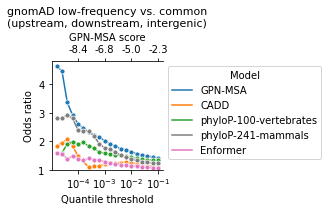

In [186]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        models[0], "CADD", "phyloP", "Enformer_l1", "phyloP-241-mammals",
    ])].replace({"Enformer_l1": "Enformer", "phyloP": "phyloP-100-vertebrates", models[0]: "GPN-MSA"}),
    #save_path="gnomad_or_enformer.svg",
)

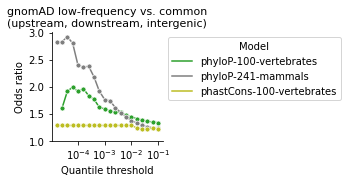

In [184]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    #save_path="gnomad_or_enformer_conservation.svg",
)

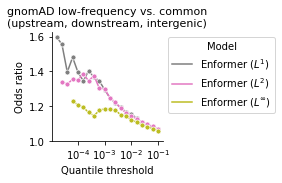

In [185]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        "Enformer_l1", "Enformer_l2", "Enformer_linf",
    ])].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    #save_path="gnomad_or_enformer_norms.pdf",
)

## Ablation study

In [136]:
results_ablation = [
    df[df.Model.isin(models[:1] + ablation_models)]
    for df in [
        results_clinvar[["Model", "AUROC"]].rename(columns={"AUROC": "ClinVar"}),
        results_cosmic[["Model", "AUPRC"]].rename(columns={"AUPRC": "COSMIC"}),
        results_omim[results_omim.Consequence=="all"][["Model", "AUPRC"]].rename(columns={"AUPRC": "OMIM"}),
        #results_gnomad[results_gnomad.Consequence=="all"][["Model", "Odds ratio"]].rename(columns={"Odds ratio": "gnomAD"}),
        #results_gnomad2[results_gnomad2.Consequence=="all"][["Model", "AP@K"]].rename(columns={"AP@K": "gnomAD"}),
    ] + [
        results_gnomad2[results_gnomad2.Consequence==c][["Model", "AP@K"]].rename(columns={"AP@K": f"gnomAD {c}"})
        for c in dataset_models["gnomAD"].keys()
    ]
]

results_ablation = reduce(lambda x, y: x.merge(y, on="Model", how="left"), results_ablation)
results_ablation

,Model,ClinVar,COSMIC,OMIM,gnomAD all,gnomAD missense,gnomAD synonymous,gnomAD 5_prime_UTR,gnomAD 3_prime_UTR,gnomAD upstream_gene,gnomAD downstream_gene,gnomAD intron,gnomAD intergenic,gnomAD non_coding_transcript_exon
0,multiz100way/89/256/128/True/defined.phastCons...,0.969021,0.353036,0.224842,0.973073,0.998111,0.893351,0.949414,0.960780,0.900059,0.775984,0.808274,0.780560,0.725467
1,multiz100way/89/128/64/True/defined.phastCons....,0.968808,0.331123,0.238804,0.973762,0.992609,0.885489,0.944646,0.961768,0.912557,0.779083,0.796670,0.792231,0.815476
2,multiz100way/89/256/128/True/defined.phastCons...,0.968684,0.347636,0.246614,0.973270,0.994526,0.873129,0.960185,0.967907,0.903863,0.763253,0.809261,0.797599,0.784838
3,multiz100way/89/256/128/True/defined.phastCons...,0.968618,0.364738,0.218789,0.971228,1.000000,0.875412,0.952945,0.964522,0.904702,0.771724,0.807256,0.797206,0.723120
4,multiz100way/89/128/64/True/defined.phastCons....,0.968483,0.344098,0.243184,0.972647,0.986492,0.901622,0.963780,0.961438,0.901904,0.781453,0.799566,0.789781,0.808625
5,multiz100way/89/128/64/True/defined.phastCons....,0.968325,0.339058,0.249266,0.973389,0.998904,0.879728,0.960474,0.966059,0.905917,0.781853,0.802109,0.792293,0.795660
6,multiz100way/89/128/64/True/defined.phastCons....,0.967901,0.321930,0.222113,0.973335,0.994571,0.896521,0.941283,0.965913,0.904500,0.779227,0.795890,0.778303,0.797907
7,multiz100way/89/128/64/True/defined.phastCons....,0.967692,0.330556,0.234654,0.972278,1.000000,0.888427,0.965327,0.969892,0.900066,0.781520,0.804864,0.778879,0.783736
8,multiz100way/89/128/64/True/defined.phastCons....,0.967619,0.338136,0.226242,0.970842,0.995468,0.915480,0.962219,0.966561,0.896589,0.776718,0.798787,0.770521,0.791054
9,multiz100way/89/128/64/True/defined.phastCons....,0.967390,0.300227,0.242532,0.972174,0.986219,0.893527,0.960827,0.968535,0.897198,0.779223,0.799703,0.793833,0.822531


In [137]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency (no neural net)",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50% most conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/[\d]+/30000/True/True/True": "Train on 100% of genome",
    
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include closest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace non-conserved",
    
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4",
}

In [138]:
results_ablation["Ablation"] = None
for k, v in hparam_name.items():
    results_ablation.loc[results_ablation.Model.str.match(k), "Ablation"] = v
results_ablation = results_ablation.dropna(subset="Ablation")
results_ablation.Ablation.value_counts()

Ablation
Window size = 256                3
Default                          3
Window size = 64                 3
Don't upweight conserved         3
Window size = 32                 3
51 vertebrates                   3
Don't replace non-conserved      3
51 mammals                       3
Window size = 16                 3
Train on 50% most conserved      3
Train on 100% of genome          3
Window size = 8                  3
Include closest primates         3
Window size = 4                  3
w/o MSA                          3
MSA frequency (no neural net)    1
Name: count, dtype: int64

In [140]:
results_ablation = results_ablation.groupby("Ablation")[
    ["ClinVar", "COSMIC", "OMIM"] +
    [f"gnomAD {c}" for c in dataset_models["gnomAD"].keys()]
].agg(["mean",])# "std"])
results_ablation.index.name = None
results_ablation = results_ablation.loc[hparam_name.values()]
results_ablation = results_ablation.round(3)
results_ablation

KeyError: 'Ablation'

In [153]:
categories = ["ClinVar", "COSMIC", "OMIM", "gnomAD", "GWAS"]
results_ablation_tex = pd.DataFrame()

def mean_std_str(mean, std):
    if pd.isna(mean):
        return "NA"
    elif pd.isna(std):
        return f"{mean:.3f}"
    else:
        return f"{mean:.3f} ± {std:.3f}"
    
def mean_str(mean, is_gnomad):
    if pd.isna(mean):
        return "NA"
    else:
        if is_gnomad:
            return f"{mean:.1f}"
        else:
            return f"{mean:.3f}"

for category in categories:
    mean_col = (category, "mean")
    std_col = (category, "std")
    
    results_ablation_tex[category] = results_ablation.apply(
        #lambda row: mean_std_str(row[mean_col], row[std_col]), axis=1
        lambda row: mean_str(row[mean_col], category=="gnomAD"), axis=1
    )
results_ablation_tex

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
Default,0.966,0.342,0.115,37.0,0.735
w/o MSA,0.582,0.014,0.000,1.9,0.654
MSA frequency (no neural net),0.947,0.266,0.030,17.3,NA
Train on 50% most conserved,0.960,0.237,0.122,28.7,0.732
Train on 100% of genome,0.957,0.207,0.119,26.5,0.730
Include closest primates,0.950,0.211,0.128,31.5,0.728
51 mammals,0.962,0.317,0.067,33.3,0.734
51 vertebrates,0.964,0.334,0.090,33.8,0.731
Don't upweight conserved,0.964,0.297,0.122,34.2,0.732
Don't replace non-conserved,0.964,0.328,0.102,33.1,0.733


In [154]:
print(results_ablation_tex.to_latex(escape="latex"))

\begin{tabular}{llllll}
\toprule
 & ClinVar & COSMIC & OMIM & gnomAD & GWAS \\
\midrule
Default & 0.966 & 0.342 & 0.115 & 37.0 & 0.735 \\
w/o MSA & 0.582 & 0.014 & 0.000 & 1.9 & 0.654 \\
MSA frequency (no neural net) & 0.947 & 0.266 & 0.030 & 17.3 & NA \\
Train on 50\% most conserved & 0.960 & 0.237 & 0.122 & 28.7 & 0.732 \\
Train on 100\% of genome & 0.957 & 0.207 & 0.119 & 26.5 & 0.730 \\
Include closest primates & 0.950 & 0.211 & 0.128 & 31.5 & 0.728 \\
51 mammals & 0.962 & 0.317 & 0.067 & 33.3 & 0.734 \\
51 vertebrates & 0.964 & 0.334 & 0.090 & 33.8 & 0.731 \\
Don't upweight conserved & 0.964 & 0.297 & 0.122 & 34.2 & 0.732 \\
Don't replace non-conserved & 0.964 & 0.328 & 0.102 & 33.1 & 0.733 \\
Window size = 256 & 0.966 & 0.359 & 0.117 & 37.3 & 0.736 \\
Window size = 64 & 0.965 & 0.334 & 0.107 & 35.8 & 0.730 \\
Window size = 32 & 0.964 & 0.317 & 0.107 & 34.9 & 0.726 \\
Window size = 16 & 0.962 & 0.242 & 0.094 & 28.6 & 0.717 \\
Window size = 8 & 0.958 & 0.188 & 0.078 & 23.3 & 0.712 

In [207]:
results_ablation_tex[results_ablation_tex.index != "MSA frequency (no neural net)"].astype(float).corr(method="spearman")

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
ClinVar,1.000000,0.955735,0.283918,0.931463,0.722453
COSMIC,0.955735,1.000000,0.254480,0.930234,0.785842
OMIM,0.283918,0.254480,1.000000,0.429339,0.443548
gnomAD,0.931463,0.930234,0.429339,1.000000,0.737032
GWAS,0.722453,0.785842,0.443548,0.737032,1.000000
